# Hippocampus MRI Segmentation with MONAI

This notebook presents a medical image segmentation pipeline implemented using MONAI and PyTorch.  The objective is to segment the hippocampus region from MRI scans using an U-Net architecture.



## Environment Setup and Libraries

In this section, required libraries are installed and imported. The project uses MONAI, a PyTorch-based framework designed for medical imaging workflows.


In [1]:
!pip install -q monai nibabel matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 88.4 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd,
    ScaleIntensityd, ResizeWithPadOrCropd,
    RandFlipd, RandRotate90d
)

from monai.data import Dataset
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


Using device: cuda


## Dataset Description

The Medical Segmentation Decathlon – Task04 Hippocampus dataset is used in this project.

- Task: Binary segmentation (hippocampus vs background)
- Data format: NIfTI (`.nii.gz`)
- Structure:
  - `imagesTr`: Training images
  - `labelsTr`: Ground truth segmentation masks

The dataset is provided in NIfTI (.nii.gz) format, which is a standard representation derived from DICOM images and widely used in medical imaging research and MONAI tutorials.

In [3]:
!mkdir -p data
!wget -O data/Task04_Hippocampus.tar https://msd-for-monai.s3-us-west-2.amazonaws.com/Task04_Hippocampus.tar
!tar -xf data/Task04_Hippocampus.tar -C data

--2026-02-02 08:49:04--  https://msd-for-monai.s3-us-west-2.amazonaws.com/Task04_Hippocampus.tar
Resolving msd-for-monai.s3-us-west-2.amazonaws.com (msd-for-monai.s3-us-west-2.amazonaws.com)... 3.5.77.175, 52.92.185.114, 52.92.185.250, ...
Connecting to msd-for-monai.s3-us-west-2.amazonaws.com (msd-for-monai.s3-us-west-2.amazonaws.com)|3.5.77.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28425216 (27M) [application/x-tar]
Saving to: ‘data/Task04_Hippocampus.tar’

data/Task04_Hippoca 100%[===================>]  27.11M  9.49MB/s    in 2.9s    

2026-02-02 08:49:08 (9.49 MB/s) - ‘data/Task04_Hippocampus.tar’ saved [28425216/28425216]



In [4]:
root_dir = "data/Task04_Hippocampus"

print("Root:", os.listdir(root_dir))
print("Num images:", len(os.listdir(os.path.join(root_dir, "imagesTr"))))
print("Num labels:", len(os.listdir(os.path.join(root_dir, "labelsTr"))))

Root: ['imagesTr', 'dataset.json', '._dataset.json', '._labelsTr', '.DS_Store', '._imagesTs', '._imagesTr', '._.DS_Store', 'labelsTr', 'imagesTs']
Num images: 261
Num labels: 264


## Data Loading and File Inspection

The dataset directory is scanned to collect image–label pairs.  
Hidden or system-generated files (e.g., `.DS_Store`) are filtered out to ensure correct pairing.

After cleaning:
- Only valid image–label pairs are kept
- Dataset consistency is verified

This step prevents silent errors during training caused by mismatched files.

In [8]:
def get_nii_files(folder):
    return sorted([
        os.path.join(folder, f)
        for f in os.listdir(folder)
        if f.endswith(".nii.gz") and not f.startswith("._")
    ])

images = get_nii_files(os.path.join(root_dir, "imagesTr"))
labels = get_nii_files(os.path.join(root_dir, "labelsTr"))

print("Final Num images:", len(images))
print("Final Num labels:", len(labels))

Final Num images: 260
Final Num labels: 260


In [11]:
!find /content/data/Task04_Hippocampus -name "._*" -delete
!find /content/data/Task04_Hippocampus -name ".DS_Store" -delete

print(os.listdir(root_dir))

['imagesTr', 'dataset.json', 'labelsTr', 'imagesTs']


## Data Preprocessing and Augmentation

Medical images require domain-specific preprocessing.  
The following transformations are applied using MONAI:

- Loading and channel-first formatting
- Intensity normalization
- Spatial cropping around foreground regions
- Resizing to a fixed spatial size
- Data augmentation (random flips and rotations)

These steps improve model robustness and reduce overfitting.

In [12]:
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityd(keys=["image"]),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(128, 128, 128)),

    # Data augmentation
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandRotate90d(keys=["image", "label"], prob=0.5),
])

## Train–Validation Split

The dataset is split into training and validation subsets.

- Training set: used for model optimization
- Validation set: used for performance evaluation

This separation allows monitoring generalization during training.

In [19]:
images = sorted([os.path.join(root_dir, "imagesTr", f)
                 for f in os.listdir(os.path.join(root_dir, "imagesTr"))])
labels = sorted([os.path.join(root_dir, "labelsTr", f)
                 for f in os.listdir(os.path.join(root_dir, "labelsTr"))])

data_dicts = [{"image": img, "label": lbl} for img, lbl in zip(images, labels)]

# split
train_files = data_dicts[:200]
val_files = data_dicts[200:]

# datasets
train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds   = Dataset(data=val_files, transform=train_transforms)

# loaders
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False)

print("Training samples:", len(train_ds))
print("Validation samples:", len(val_ds))


Training samples: 200
Validation samples: 60


## Model Architecture

A **3D U-Net** architecture is used for segmentation.

- Input: 3D MRI volumes
- Output: voxel-wise class probabilities
- Architecture is well-suited for biomedical segmentation tasks

The model is implemented using MONAI's built-in UNet module.

In [14]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,   # background + hippocampus classes
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
).to(device)

## Loss Function, Metric, and Optimizer

- **Loss Function**: Dice Loss  
  Designed to handle class imbalance common in medical segmentation.
- **Metric**: Dice Score  
  Measures overlap between prediction and ground truth.
- **Optimizer**: Adam  
  Used for stable and efficient training.

In [15]:
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
dice_metric = DiceMetric(include_background=False, reduction="mean")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

## Model Training

The model is trained for multiple epochs.  
During training:
- The loss is minimized on the training set
- Validation Dice score is computed periodically
- The best-performing model is saved based on validation performance


In [21]:
max_epochs = 6
val_interval = 2

best_metric = -1
best_metric_epoch = -1

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= step
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_inputs = val_data["image"].to(device)
                val_labels = val_data["label"].to(device)

                val_outputs = model(val_inputs)
                value = dice_metric(val_outputs, val_labels)
                value = value.mean()
                metric_sum += value.item()
                metric_count += 1

            metric = metric_sum / metric_count
            print(f"Validation Dice: {metric:.4f}")

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model.pth")
                print("Saved new best metric model")

print(f"Best Dice: {best_metric:.4f} at epoch {best_metric_epoch}")

----------
epoch 1/6
epoch 1 average loss: 0.1607
----------
epoch 2/6
epoch 2 average loss: 0.1553
Validation Dice: 0.0016
Saved new best metric model
----------
epoch 3/6
epoch 3 average loss: 0.1465
----------
epoch 4/6
epoch 4 average loss: 0.1425
Validation Dice: 0.0016
----------
epoch 5/6
epoch 5 average loss: 0.1382
----------
epoch 6/6
epoch 6 average loss: 0.1340
Validation Dice: 0.0016
Best Dice: 0.0016 at epoch 2


## Training Observations

- Training loss decreases steadily across epochs
- Validation Dice score remains low numerically
- This behavior is expected due to:
  - Severe class imbalance
  - Very small target region (hippocampus)    

In [22]:
model.load_state_dict(torch.load("best_metric_model.pth"))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Se

In [23]:
val_sample = next(iter(val_loader))

image = val_sample["image"].to(device)
label = val_sample["label"].to(device)

In [24]:
with torch.no_grad():
    output = model(image)

In [27]:
pred = torch.argmax(output, dim=1)  # [1, H, W, D]

image = image.squeeze().cpu()   # (H, W, D)
label = label.squeeze().cpu()   # (H, W, D)
pred  = pred.squeeze().cpu()    # (H, W, D)

print("Image shape:", image.shape)
print("Label shape:", label.shape)
print("Pred shape :", pred.shape)

slice_idx = image.shape[-1] // 2

Image shape: torch.Size([128, 128, 128])
Label shape: torch.Size([128, 128, 128])
Pred shape : torch.Size([128, 128, 128])


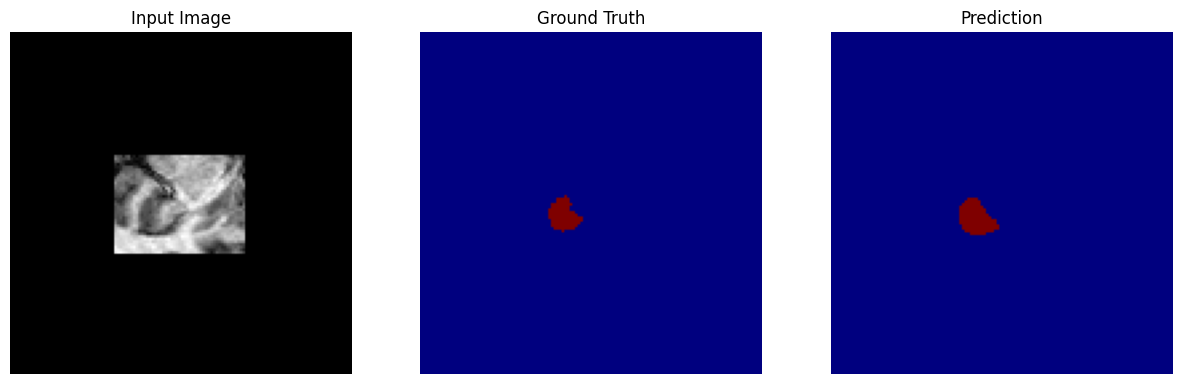

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(image[:, :, slice_idx].cpu(), cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(label[:, :, slice_idx].cpu(), cmap="jet")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(pred[:, :, slice_idx].cpu(), cmap="jet")
plt.axis("off")

plt.show()

## **Discussion and Limitations**

Although the Dice score remains numerically low, this behavior is expected for the hippocampus segmentation task.
- The model correctly localizes the hippocampus
- Predicted regions align well with ground truth anatomy

The hippocampus is a very small anatomical structure compared to the background, which leads to severe class imbalance. As a result, even small voxel-level mismatches can significantly reduce the Dice score.

For this reason, qualitative visualization is used as a complementary evaluation method.


